In [1]:
from __future__ import division
import menpo3d.io as m3dio
import menpo.io as mio
import menpo3d
import numpy as np
import mappings

from io import BytesIO
from scipy.io import loadmat, savemat
from functools import reduce
from pathlib import Path

from menpo.image import Image
from menpo.transform import AlignmentSimilarity
from menpo.shape import PointCloud, TriMesh, ColouredTriMesh, TexturedTriMesh
from menpo.transform import UniformScale, Translation, Homogeneous, Scale
from menpo3d.rasterize import GLRasterizer
from menpo.visualize import print_progress
from utils_3d import (retrieve_camera_matrix, 
                      weak_projection_matrix, crop_face, clip_texture, nostdout,
                      duplicate_vertices, clip_to_image)


np.set_printoptions(precision=3, suppress=True)

In [2]:
shape_mdl, lms = mappings.load_lsfm_combined_fw()

In [3]:
texture_mdl = mio.import_pickle('/vol/construct3dmm/experiments/modelstexture/mein3d/full_unmasked_all_1000.pkl')['model']

In [104]:
texture_mdl.components.shape

(1000, 554340)

In [105]:
def create_instance():
    shape = shape_mdl.instance(np.random.randn(200,), True)
    texture = clip_texture(texture_mdl.instance(np.random.randn(1000), True))
    mesh = TexturedTriMesh(shape.points, tcoords, texture.as_unmasked(), trilist=shape.trilist)
    mesh.landmarks['ibug68'] = lms
    return mesh

In [5]:
tcoords = mio.import_pickle('/vol/construct3dmm/experiments/nicptexture/settings.pkl')['tcoords']
map_basel_to_mein3d = mio.import_pickle('/vol/atlas/databases/lsfm/mapping_mein3d_to_tddfa.pkl.gz')['map_basel_to_mein3d']
tcoords = tcoords.points[map_basel_to_mein3d][mappings.map_tddfa_to_basel()]

In [6]:
axes_flip_matrix = np.eye(4)
axes_flip_matrix[1, 1] = -1
axes_flip_matrix[2, 2] = -1
axes_flip_t = Homogeneous(axes_flip_matrix)

In [7]:
from menpo3d.rasterize import rasterize_mesh, rasterize_barycentric_coordinate_images, rasterize_mesh_from_barycentric_coordinate_images

In [8]:
def rasterize_mesh_with_normals(mesh_in_img, normals, image_shape):
    bcs = rasterize_barycentric_coordinate_images(mesh_in_img, image_shape)
    
    rgb_image = rasterize_mesh_from_barycentric_coordinate_images(mesh_in_img, *bcs)
    
    normal_mesh = as_colourtrimesh(mesh_in_img)
    normal_mesh.colours = normals
    
    normals = rasterize_mesh_from_barycentric_coordinate_images(normal_mesh, *bcs)    
    return rgb_image, normals

In [9]:
def as_colourtrimesh(mesh):
    return ColouredTriMesh(mesh.points, mesh.trilist, mesh.texture.sample(mesh.tcoords_pixel_scaled()).T)

In [10]:
def clip_to_image(height, width): 
    # 2. invert the y direction (up becomes down)
    invert_y = Scale([1, -1, 1])
    # 3. [-1, 1] [-1, 1] -> [0, 2] [0, 2] [0, 2]
    t = Translation([1, 1, 0])
    # 4. [0, 2] [0, 2] -> [0, 1] [0, 1]
    unit_scale = Scale(0.5, n_dims=3)
    # 5. [0, 1] [0, 1] -> [0, w] [0, h]
    im_scale = Scale([width, height, 1])
    # 6. [0, w] [0, h] -> [0, h] [0, w]
    xy_yx = Homogeneous(np.array([[0, 1, 0, 0],
                                  [1, 0, 0, 0],
                                  [0, 0, 1, 0],
                                  [0, 0, 0, 1]], dtype=np.float))
    # reduce the full transform chain to a single affine matrix
    transforms = [invert_y, t, unit_scale, im_scale, xy_yx]
    return reduce(lambda a, b: a.compose_before(b), transforms)

In [11]:
def render_image(mesh, normals, shape):
#     mesh.landmarks.clear()
    mesh_in_image = clip_to_image(*shape).apply(mesh)

    rgb_image, normals = rasterize_mesh_with_normals(mesh_in_image, normals, shape)

    normals.pixels[:, ~normals.mask.pixels[0]] = -1

    return rgb_image, normals

def model_to_clip_space(im, mesh):
    view_t, _, proj_t = retrieve_camera_matrix(im, mesh, initialize=True)
    proj_t = weak_projection_matrix(im.shape[1], im.shape[0], view_t.apply(mesh))
    view_t = view_t.compose_before(axes_flip_t)
    transform = Homogeneous(proj_t.dot(view_t.h_matrix))
    return transform, view_t

def get_rendered_mesh(im):
    im = im.copy()
    mesh = create_instance()

    transform, view_transform = model_to_clip_space(im, mesh)
    normals = view_transform.apply(mesh).vertex_normals()
    rendered_image, gt = render_image(transform.apply(mesh), normals, im.shape)
    
    mask = rendered_image.mask.pixels[0]
    im.pixels[:, mask] = rendered_image.pixels[:, mask]
    
    return im, gt

(920, 896)


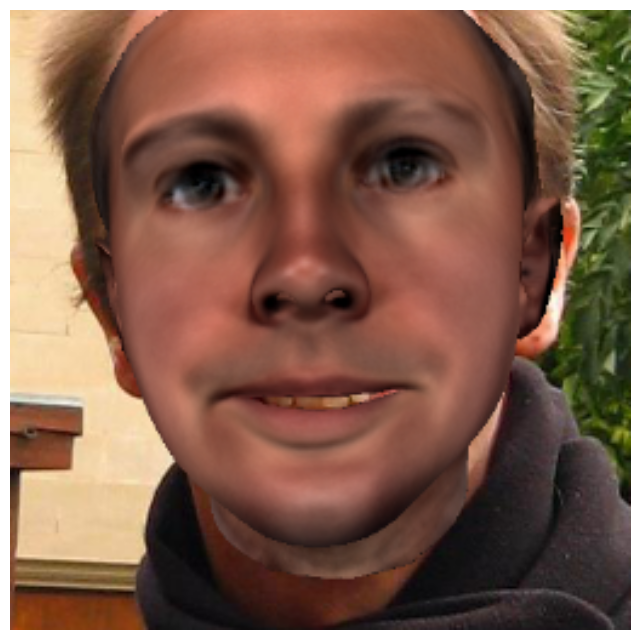

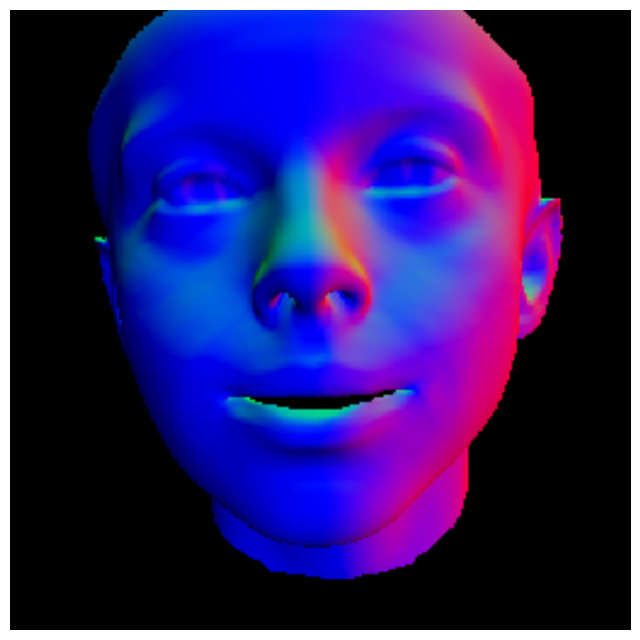

In [108]:
%matplotlib inline

im = mio.import_images('/vol/atlas/databases/helen/trainset/')[30]
im = im.crop_to_landmarks_proportion(1)
rendering, normals = get_rendered_mesh(im)
print(im.shape)
normals.landmarks['PTS'] = rendering.landmarks[None]
rendering = crop_face(rendering)
normals = crop_face(normals, order=0)

rendering.view()
normals.view(new_figure=True)

In [36]:
a = normals.pixels[2][normals.pixels[2]  > -1].copy()
a.sort()
a[:20]

array([-0.486, -0.486, -0.466, -0.444, -0.376, -0.134, -0.027, -0.02 ,
       -0.02 , -0.02 , -0.02 , -0.018, -0.018,  0.016,  0.023,  0.023,
        0.025,  0.045,  0.045,  0.045])

In [52]:
normals.pixels[0][normals.pixels[0] > -1].max()

0.98070764556122625

In [78]:
def normalise(nrm):
    nrm = nrm.copy()
    nrm.pixels += np.array([1, 1, 0])[:, None, None]
    nrm.pixels /= np.array([2, 2, 1])[:, None, None]
#     nrm.pixels = (nrm.pixels)
    return nrm

In [59]:
import matplotlib.pyplot as plt

In [85]:
normals.masked_pixels()[0].mean()

0.092424728375532825

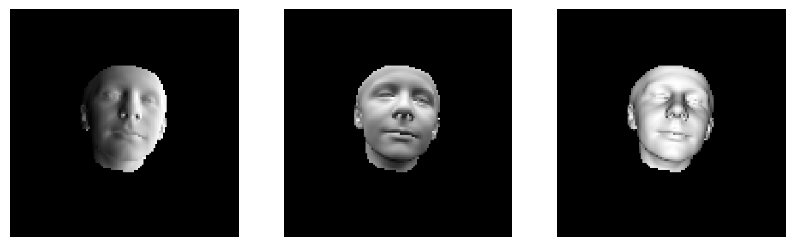

In [112]:
normalise(normals).as_unmasked().view(channels='all')

In [14]:
def _int_feauture(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feauture(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_jpg_string(im):
    '''Serializes an `Image` to bytes.'''
    fp = BytesIO()
    mio.export_image(im, fp, extension='jpg')
    fp.seek(0)
    return fp.read()

def serialize_sample(image, normals):
    height, width = image.shape
    
    example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int_feauture(height),
                'width': _int_feauture(width),
                'image': _bytes_feauture(get_jpg_string(image)),
                'normals': _bytes_feauture(normals.pixels_with_channels_at_back().astype(np.float32).tobytes())
    }))
    
    return example

In [111]:
import tensorflow as tf

In [122]:
path = '/vol/atlas/databases/tf_records/synthetic_normals_600x600.tfrecords'
writer = tf.python_io.TFRecordWriter(path)

In [119]:
all_images = mio.import_images('/vol/atlas/databases/aflw_ibug/', normalise=True)

/vol/atlas/homes/gt108/Projects/menpo/menpo/io/input/base.py:26: MenpoDeprecationWarning: normalise is no longer supported and will be removed in a future version of Menpo. Use normalize instead.
  MenpoDeprecationWarning)


In [120]:
image_size = (600, 600)

In [118]:
im.rescale_to_diagonal(1000).shape

(716, 699)

In [ ]:
for i in print_progress(range(len(all_images))):
    try:
        im = all_images[i]
        if im.landmarks[None].lms.n_points != 68:
            continue
            
        im = im.crop_to_landmarks_proportion(1)
        im = im.rescale_to_diagonal(981)

        for _ in range(3):
            rgb_image, normals = get_rendered_mesh(im)
            normals.landmarks['PTS'] = rgb_image.landmarks[None]
            rgb_image = crop_face(rgb_image, shape=image_size)
            normals = crop_face(normals, shape=image_size, order=0)


            example = serialize_sample(rgb_image, normals)
            writer.write(example.SerializeToString())
            
    except Exception as e:
        print(e)
        
writer.close()

[                    ] 0% (15/14193) - 11:03:59 remaining                       All max indices must be greater that the min indices
[                    ] 0% (18/14193) - 09:15:53 remaining                       

/vol/atlas/homes/gt108/Projects/menpo/menpo/image/base.py:1166: RuntimeWarning: invalid value encountered in greater
  elif not np.all(max_indices > min_indices):


[                    ] 0% (27/14193) - 07:32:25 remaining                       